# Learning from Imbalanced Data

과제내용
- Imbalanced learning 기법 간 성능 비교
- 상세내용은 아래 실험방법 참조


•데이터
- Kaggle Competition으로 2017년말에 개최되었던 "WSDM - KKBox's Music Recommendation Challenge" 데이터에 Feature Engineering을 적용한 것을 사용한다. 
(첨부화일)


•실험방법
- class 변수인 'target' 필드에서 1의 값이 전체 데이터의 0.1%, 1%, 10%가 되도록 축소하여 3가지의 data imbalance 상황을 만든다.
(필요시 위에 더하여 새로운 imbalance 상황을 추가할 수 있음)
- 각각의 data imbalance 상황에서, 여러 Imbalanced learning 기법을 적용한 데이터에 대해  RandomForest 알고리즘을 적용하여 성능을 평가하고 비교한다. 
(존재하는 feature를 수정하지 않고 그대로 사용함)
- 평가척도로는 Accuracy, ROC-AUC, Recall, Precision, F1-score 등 5가지를 사용하고, "Survey of resampling techniques for improving classification performance in unbalanced datasets" 논문(첨부화일)에서 테스트한 기법 중 imbalanced-learn 패키지에서 지원하는 것은 모두 테스트한다.


•제출물
- 소스코드(화일명: 이름1-이름2.ipynb)와 결과보고서(화일명: 이름1-이름2.ppt)
- 4월22일 수업시간에 팀당 10분 이내 발표


•유의사항
- 마감시간 내에 제출한 과제만 평가함. 
- 반드시, 담당교수 이메일(www4u@kookmin.ac.kr)로 제출해야 하고, 메일 제목은 "팀과제(2차) 이름1-이름2"로 할 것.


In [112]:
# ! pip install -U imbalanced-learn # U 하면 새버전으로 깔림.

In [113]:
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from collections import Counter
from sklearn.svm import SVC

In [114]:
data = pd.read_csv("WSDM_train_full_features.csv")

In [115]:
data.head()

,target,user_idx,song_idx,ssn_idx,sst_idx,st_idx,song_length,genr_idx,art_idx,com_idx,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
0,1,0,0,0,0,0,206471,7,1877,7450,...,0,2,0,0,0,0,0,1,215,1140
1,1,1,1,1,1,1,284584,18,92,2,...,0,1,0,0,0,0,0,0,1,303616
2,1,1,2,1,1,1,225396,18,527,100234,...,0,1,0,0,0,0,0,1,4,289
3,1,1,3,1,1,1,255512,229,89592,193180,...,0,1,0,0,0,0,0,0,1,1
4,1,0,4,0,0,0,187802,13,195,137,...,0,3,0,0,0,0,0,1,412,427


In [116]:
data=data.iloc[0:round(len(data)/2),:]
data.shape

(3688709, 30)

In [117]:
data=data.iloc[0:round(len(data)/2),:]
data.shape

(1844354, 30)

In [118]:
data=data.iloc[0:round(len(data)/2),:]
data.shape

(922177, 30)

In [119]:
data_0 = data[data['target']==0]
data_1 = data[data['target']==1]

In [120]:
print(data_0.shape[0])
print(data_1.shape[0])  # 비슷한 크기 -> 둘 중 하나의 값을 줄여야한다.

279715
642462


In [121]:
data_1_01 = data_1.iloc[np.random.randint(0,len(data_1),size=round((1/9)*len(data_0)))]
print(data_1_01.shape)
print(data_1_01.head())

(31079, 30)
        target  user_idx  song_idx  ssn_idx  sst_idx  st_idx  song_length  \
222838       1      1935      2210        1        1       2       231084   
404666       1     12612      1813        1        1       2       220734   
229139       1      4559      1189        3        1       2       288705   
109156       1      3705     18140        9        5       7       196255   
478408       1     13559      2310        1        1       2       233314   

        genr_idx  art_idx  com_idx         ...           lyricists_count  \
222838         4      844     1217         ...                         0   
404666         0     2194     1661         ...                         0   
229139         4       58       48         ...                         0   
109156         0     6320    17448         ...                         0   
478408         0        6        7         ...                         0   

        composer_count  is_featured  artist_count  artist_composer  

In [122]:
df = pd.concat([data_0,data_1_01],axis=0)
df.head()
df.shape

(310794, 30)

In [123]:
data.shape # 원본데이터

(922177, 30)

In [124]:
X = df.iloc[:,1:30]
y = df.iloc[:,0]

In [125]:
# 학습/평가 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape

((233095, 29), (77699, 29))

## SCORE 모아두기

In [126]:
accuracy = []
roc_auc = []
f1 = []
recall = []
precision = []

# 1. BaseLine

In [127]:
# 원래 데이터를 사용했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_train, y_train).predict(X_test)
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.9001660253027709 
 roc_auc_score : 0.9999999999999999 
 f1_score : 0.13455316300345865 
 recall_score : 0.07874118568816924 
 precision_score : 0.46206896551724136


In [128]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

In [129]:
print(accuracy)
print(roc_auc )
print(f1 )
print(recall)
print(precision )

[0.9001660253027709]
[0.9999999999999999]
[0.13455316300345865]
[0.07874118568816924]
[0.46206896551724136]


# Under_Sampling
# 2-1. NearMiss1. 

In [130]:
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1,random_state=0)

In [131]:
X_resampled_nm1, y_resampled = nm1.fit_sample(X_train, y_train)
X_resampled_nm1.shape

(46842, 29)

In [132]:
accuracy_score(y_test, y_pred)

0.9001660253027709

In [133]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_resampled_nm1, y_resampled).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_resampled_nm1, y_resampled).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))
print()

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.27220427547330084 
 roc_auc_score : 0.47579945796699336 
 f1_score : 0.16867824118312924 
 recall_score : 0.7491512144162967 
 precision_score : 0.09503851569618156



In [134]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.22      0.35     70041
           1       0.10      0.75      0.17      7658

   micro avg       0.27      0.27      0.27     77699
   macro avg       0.49      0.48      0.26     77699
weighted avg       0.81      0.27      0.33     77699



In [135]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 2-2. NearMiss2. 

from imblearn.under_sampling import NearMiss
nm2 = NearMiss(version=2,random_state=0)

X_resampled_nm2, y_resampled = nm2.fit_sample(X_train, y_train)
X_resampled_nm2.shape

# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_resampled_nm2, y_resampled).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 2-3. NearMiss3. 

In [136]:
from imblearn.under_sampling import NearMiss
nm3 = NearMiss(version=3,random_state=0)

In [137]:
X_resampled_nm3, y_resampled = nm3.fit_sample(X_train, y_train)
X_resampled_nm3.shape

(46842, 29)

In [138]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_resampled_nm3, y_resampled).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


 accuracy_score : 0.6038301651243903 
 roc_auc_score : 0.8670817043253354 
 f1_score : 0.24760461478294873 
 recall_score : 0.661399843301123 
 precision_score : 0.15231250375894628


In [139]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 3. RandomUnderSampler

In [140]:
from imblearn.under_sampling import RandomUnderSampler 

In [141]:
rus = RandomUnderSampler(random_state=0)

In [142]:
X_res, y_res = rus.fit_resample(X_train, y_train)

In [143]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n roc_auc_score :',roc_auc_score(y_test, y_proba), '\n f1_score :', f1_score(y_test, y_pred), '\n recall_score :',recall_score(y_test, y_pred),'\n precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.6951312114699031 
 roc_auc_score : 0.7255490627101229 
 f1_score : 0.288092805193244 
 recall_score : 0.6258814311830765 
 precision_score : 0.18710961898813241


In [144]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 4. Condensed Nearest Neighbor (CNN)

from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=0)

X_res, y_res = cnn.fit_resample(X_train, y_train)

# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred)

accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 5. Edited Nearest Neighbor (ENN)

In [145]:
from imblearn.under_sampling import EditedNearestNeighbours

In [146]:
enn = EditedNearestNeighbours(random_state=0)

In [147]:
X_res, y_res = enn.fit_resample(X_train, y_train)

In [148]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n roc_auc_score :',roc_auc_score(y_test, y_proba), '\n f1_score :', f1_score(y_test, y_pred), '\n recall_score :',recall_score(y_test, y_pred), '\n precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.8873601976859419 
 roc_auc_score : 0.712786193367494 
 f1_score : 0.21153153153153154 
 recall_score : 0.1533037346565683 
 precision_score : 0.3410807669959326


In [149]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 6. Repeated Edited Nearest Neighbor 

In [150]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours 

In [151]:
renn = RepeatedEditedNearestNeighbours(random_state=0)

In [152]:
X_res, y_res = renn.fit_resample(X_train, y_train)

In [153]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.8655452451125497 
 roc_auc_score : 0.7175821186090425 
 f1_score : 0.2545843738851231 
 recall_score : 0.23295899712718726 
 precision_score : 0.28063551989932356


In [154]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 7. Tomek Link Removal

In [155]:
from imblearn.under_sampling import TomekLinks 

In [156]:
tl = TomekLinks(random_state=0)

In [157]:
X_res, y_res = tl.fit_resample(X_train, y_train)

In [158]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.8992007619145678 
 roc_auc_score : 0.7094249555484587 
 f1_score : 0.15219744533448798 
 recall_score : 0.09179942543745104 
 precision_score : 0.4449367088607595


In [159]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# Oversampling methods
# 1. Random oversampling of minority class

In [160]:
from imblearn.over_sampling import RandomOverSampler

In [161]:
ros = RandomOverSampler(random_state=0)

In [162]:
X_res, y_res = ros.fit_resample(X_train, y_train)

In [163]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.893627974620008 
 roc_auc_score : 0.7172965678435653 
 f1_score : 0.19357986144989756 
 recall_score : 0.12953773831287543 
 precision_score : 0.382863759166345


In [164]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 2. SMOTE

In [165]:
from imblearn.over_sampling import SMOTE

In [166]:
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X_train, y_train)

In [167]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_resampled, y_resampled).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.8786985675491319 
 roc_auc_score : 0.7172965678435653 
 f1_score : 0.2851725445582101 
 recall_score : 0.24549490728649778 
 precision_score : 0.34014836258368014


In [168]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 3-1. Borderline-SMOTE1

In [169]:
from imblearn.over_sampling import BorderlineSMOTE

In [170]:
X_resampled, y_resampled = BorderlineSMOTE(kind='borderline-1',random_state=0).fit_resample(X_train, y_train)

In [171]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_resampled, y_resampled).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.8812082523584602 
 roc_auc_score : 0.7172965678435653 
 f1_score : 0.2650103519668737 
 recall_score : 0.2172891094280491 
 precision_score : 0.3395918367346939


In [172]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 3-2.Borderline-SMOTE2

In [173]:
X_resampled, y_resampled = BorderlineSMOTE(kind='borderline-2',random_state=0).fit_resample(X_train, y_train)

In [174]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_resampled, y_resampled).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.8788015289772069 
 roc_auc_score : 0.7172965678435653 
 f1_score : 0.2698301930681553 
 recall_score : 0.22721337163750327 
 precision_score : 0.332124451231151


In [175]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# Combination methods
# 1. SMOTE + Tomek Link Removal

In [176]:
from imblearn.combine import SMOTETomek

In [177]:
smt = SMOTETomek(random_state=0)

In [178]:
 X_res, y_res = smt.fit_resample(X_train, y_train)

In [179]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.8746702016756972 
 roc_auc_score : 0.7377087279204286 
 f1_score : 0.28175247086590943 
 recall_score : 0.24941237921128231 
 precision_score : 0.32372881355932204


In [180]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 2. SMOTE + ENN

In [181]:
 from imblearn.combine import SMOTEENN

In [182]:
sme = SMOTEENN(random_state=42)

In [183]:
X_res, y_res = sme.fit_resample(X_train, y_train)

In [184]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 accuracy_score : 0.8453519350313389 
 roc_auc_score : 0.7381273043413751 
 f1_score : 0.3018824076225889 
 recall_score : 0.3392530686863411 
 precision_score : 0.2719279882771614


In [185]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# Ensemble Methods
# 1. EasyEnsemble

In [186]:
from imblearn.ensemble import EasyEnsemble

In [187]:
ee = EasyEnsemble(random_state=0)

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class EasyEnsemble is deprecated; EasyEnsemble is deprecated in 0.4 and will be removed in 0.6. Use EasyEnsembleClassifier instead.
  warnings.warn(msg, category=DeprecationWarning)


In [188]:
X_res, y_res = ee.fit_resample(X, y)

In [189]:
X_res=X_res.reshape(-1,29) # -1 행개수를 지정하지 않겠다.
y_res=y_res.reshape(-1,1) # -1 행개수를 지정하지 않겠다.

In [190]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports u

In [191]:
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n roc_auc_score :',roc_auc_score(y_test, y_proba), '\n f1_score :', f1_score(y_test, y_pred), '\n recall_score :',recall_score(y_test, y_pred),'\n precision_score :', precision_score(y_test, y_pred))

 accuracy_score : 0.9906305100451743 
 roc_auc_score : 0.9998928667266554 
 f1_score : 0.9546247818499128 
 recall_score : 1.0 
 precision_score : 0.9131886477462438


In [192]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

# 2. BalanceCascade

In [193]:
from imblearn.ensemble import BalanceCascade

In [194]:
bc = BalanceCascade(random_state=42)

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class BalanceCascade is deprecated; BalanceCascade is deprecated in 0.4 and will be removed in 0.6.
  warnings.warn(msg, category=DeprecationWarning)


In [195]:
X_res, y_res = bc.fit_resample(X, y)

In [196]:
X_res=X_res.reshape(-1,29) # -1 행개수를 지정하지 않겠다.
y_res=y_res.reshape(-1,1) # -1 행개수를 지정하지 않겠다.

In [197]:
# 합성 데이터를 추가했을 때의 모델성능
y_pred = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict(X_test)
y_proba = RandomForestClassifier(random_state=0).fit(X_res, y_res).predict_proba(X_test)[:,1]
print(' accuracy_score :', accuracy_score(y_test, y_pred), '\n' ,'roc_auc_score :',roc_auc_score(y_test, y_proba), '\n','f1_score :', f1_score(y_test, y_pred), '\n','recall_score :',recall_score(y_test, y_pred),'\n','precision_score :', precision_score(y_test, y_pred))

C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\Bae yuna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bae yuna\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports u

 accuracy_score : 0.9999099087504344 
 roc_auc_score : 1.0 
 f1_score : 0.9995431703974418 
 recall_score : 1.0 
 precision_score : 0.9990867579908675


In [198]:
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_proba))
f1.append(f1_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred))

In [199]:
print(accuracy)
print(roc_auc )
print(f1 )
print(recall)
print(precision )

[0.9001660253027709, 0.27220427547330084, 0.6038301651243903, 0.6951312114699031, 0.8873601976859419, 0.8655452451125497, 0.8992007619145678, 0.893627974620008, 0.8786985675491319, 0.8812082523584602, 0.8788015289772069, 0.8746702016756972, 0.8453519350313389, 0.9906305100451743, 0.9999099087504344]
[0.9999999999999999, 0.47579945796699336, 0.8670817043253354, 0.7255490627101229, 0.712786193367494, 0.7175821186090425, 0.7094249555484587, 0.7172965678435653, 0.7172965678435653, 0.7172965678435653, 0.7172965678435653, 0.7377087279204286, 0.7381273043413751, 0.9998928667266554, 1.0]
[0.13455316300345865, 0.16867824118312924, 0.24760461478294873, 0.288092805193244, 0.21153153153153154, 0.2545843738851231, 0.15219744533448798, 0.19357986144989756, 0.2851725445582101, 0.2650103519668737, 0.2698301930681553, 0.28175247086590943, 0.3018824076225889, 0.9546247818499128, 0.9995431703974418]
[0.07874118568816924, 0.7491512144162967, 0.661399843301123, 0.6258814311830765, 0.1533037346565683, 0.232

# 시각화

In [200]:
lsts = [accuracy, roc_auc, f1, recall, precision]
score = pd.DataFrame(lsts,index=['accuracy', 'roc_auc', 'f1', 'recall', 'precision'])
print(score)

                 0         1         2         3         4         5   \
accuracy   0.900166  0.272204  0.603830  0.695131  0.887360  0.865545   
roc_auc    1.000000  0.475799  0.867082  0.725549  0.712786  0.717582   
f1         0.134553  0.168678  0.247605  0.288093  0.211532  0.254584   
recall     0.078741  0.749151  0.661400  0.625881  0.153304  0.232959   
precision  0.462069  0.095039  0.152313  0.187110  0.341081  0.280636   

                 6         7         8         9         10        11  \
accuracy   0.899201  0.893628  0.878699  0.881208  0.878802  0.874670   
roc_auc    0.709425  0.717297  0.717297  0.717297  0.717297  0.737709   
f1         0.152197  0.193580  0.285173  0.265010  0.269830  0.281752   
recall     0.091799  0.129538  0.245495  0.217289  0.227213  0.249412   
precision  0.444937  0.382864  0.340148  0.339592  0.332124  0.323729   

                 12        13        14  
accuracy   0.845352  0.990631  0.999910  
roc_auc    0.738127  0.999893  1.00000

In [201]:
score.columns=['BaseLine','NearMiss1','NearMiss3','RandomUnderSampler','ENN','Repeated_edites_nearest_neighbor','Tomek_Link_Removal','Random_Oversampling_of_minority_class','SMOTE','SMOTE1','SMOTE2','SMOTE+TOMEK','SMOTE+ENN','EasyEnsemble','BalanceCascade']
print(score)

           BaseLine  NearMiss1  NearMiss3  RandomUnderSampler       ENN  \
accuracy   0.900166   0.272204   0.603830            0.695131  0.887360   
roc_auc    1.000000   0.475799   0.867082            0.725549  0.712786   
f1         0.134553   0.168678   0.247605            0.288093  0.211532   
recall     0.078741   0.749151   0.661400            0.625881  0.153304   
precision  0.462069   0.095039   0.152313            0.187110  0.341081   

           Repeated_edites_nearest_neighbor  Tomek_Link_Removal  \
accuracy                           0.865545            0.899201   
roc_auc                            0.717582            0.709425   
f1                                 0.254584            0.152197   
recall                             0.232959            0.091799   
precision                          0.280636            0.444937   

           Random_Oversampling_of_minority_class     SMOTE    SMOTE1  \
accuracy                                0.893628  0.878699  0.881208   
ro

In [205]:
score['score']=['accuracy','roc_auc','f1','recall','precision']

In [206]:
print(score)

           BaseLine  NearMiss1  NearMiss3  RandomUnderSampler       ENN  \
accuracy   0.900166   0.272204   0.603830            0.695131  0.887360   
roc_auc    1.000000   0.475799   0.867082            0.725549  0.712786   
f1         0.134553   0.168678   0.247605            0.288093  0.211532   
recall     0.078741   0.749151   0.661400            0.625881  0.153304   
precision  0.462069   0.095039   0.152313            0.187110  0.341081   

           Repeated_edites_nearest_neighbor  Tomek_Link_Removal  \
accuracy                           0.865545            0.899201   
roc_auc                            0.717582            0.709425   
f1                                 0.254584            0.152197   
recall                             0.232959            0.091799   
precision                          0.280636            0.444937   

           Random_Oversampling_of_minority_class     SMOTE    SMOTE1  \
accuracy                                0.893628  0.878699  0.881208   
ro

## 각 모델별 score 시각화

## 1. BaseLine score 시각화

Text(0.5, 1.0, 'BaseLine Score')

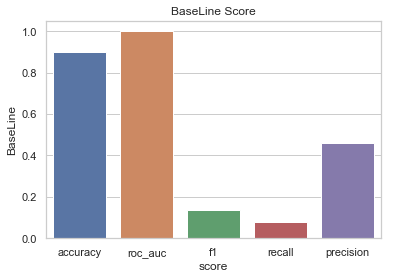

In [209]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="BaseLine", data=score)
ax.set_title('BaseLine Score')

## 2. UnderSampling 시각화

Text(0.5, 1.0, 'NearMiss1 Score')

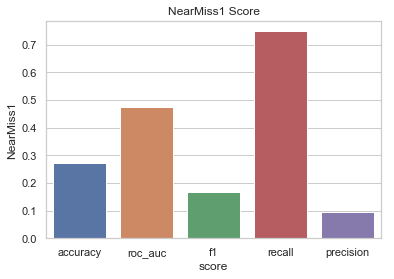

In [210]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="NearMiss1", data=score)
ax.set_title('NearMiss1 Score')

Text(0.5, 1.0, 'NearMiss3 Score')

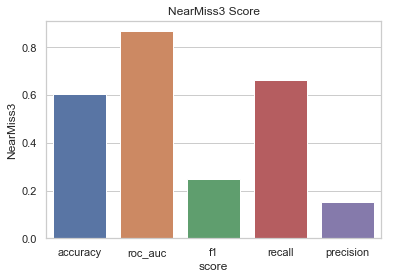

In [211]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="NearMiss3", data=score)
ax.set_title('NearMiss3 Score')

Text(0.5, 1.0, 'RandomUnderSampler')

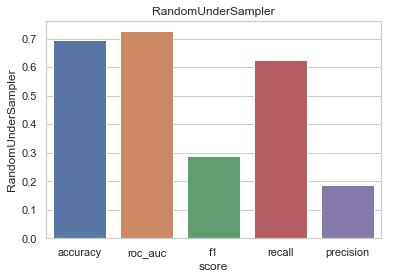

In [212]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="RandomUnderSampler", data=score)
ax.set_title('RandomUnderSampler')

Text(0.5, 1.0, 'ENN')

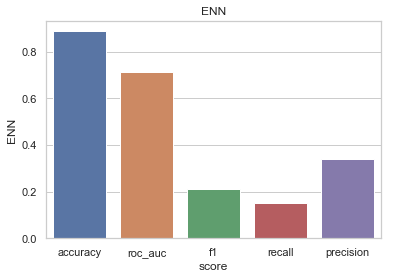

In [213]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="ENN", data=score)
ax.set_title('ENN')

Text(0.5, 1.0, 'Repeated_edites_nearest_neighbor Score')

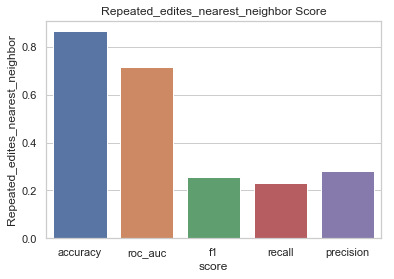

In [214]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="Repeated_edites_nearest_neighbor", data=score)
ax.set_title('Repeated_edites_nearest_neighbor Score')

Text(0.5, 1.0, 'Tomek_Link_Removal Score')

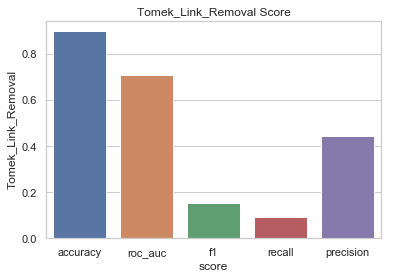

In [215]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="Tomek_Link_Removal", data=score)
ax.set_title('Tomek_Link_Removal Score')

## OverSampling 시각화

Text(0.5, 1.0, 'Random_Oversampling_of_minority_class Score')

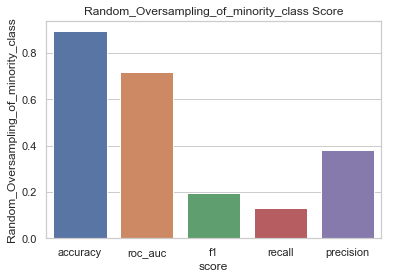

In [216]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="Random_Oversampling_of_minority_class", data=score)
ax.set_title('Random_Oversampling_of_minority_class Score')

Text(0.5, 1.0, 'SMOTE Score')

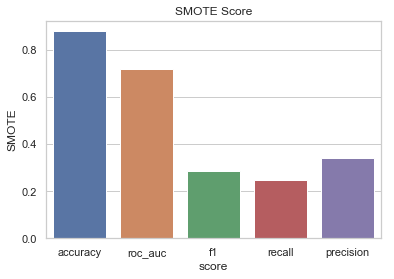

In [217]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="SMOTE", data=score)
ax.set_title('SMOTE Score')

Text(0.5, 1.0, 'SMOTE1 Score')

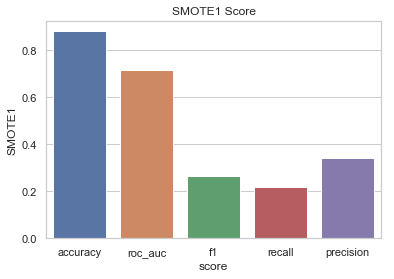

In [218]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="SMOTE1", data=score)
ax.set_title('SMOTE1 Score')

Text(0.5, 1.0, 'SMOTE2 Score')

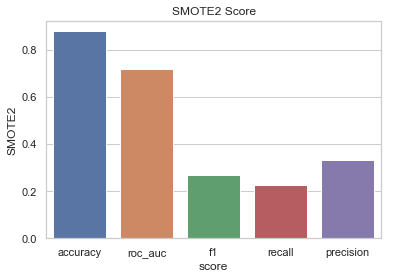

In [219]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="SMOTE2", data=score)
ax.set_title('SMOTE2 Score')

Text(0.5, 1.0, 'SMOTE+TOMEK Score')

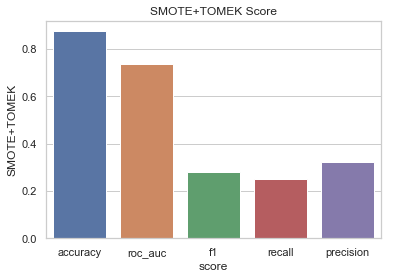

In [221]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="SMOTE+TOMEK", data=score)
ax.set_title('SMOTE+TOMEK Score')

Text(0.5, 1.0, 'SMOTE+ENN Score')

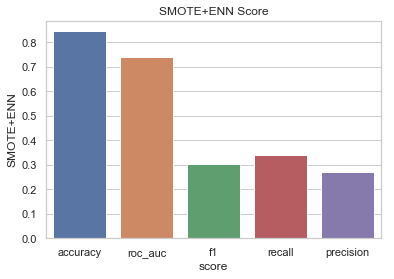

In [222]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="SMOTE+ENN", data=score)
ax.set_title('SMOTE+ENN Score')

## 3. Ensemble 시각화

Text(0.5, 1.0, 'EasyEnsemble Score')

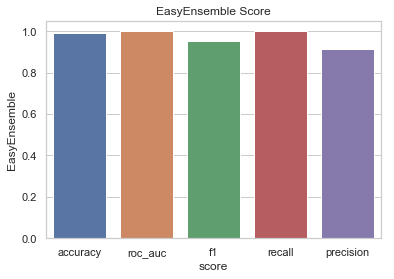

In [223]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="EasyEnsemble", data=score)
ax.set_title('EasyEnsemble Score')

(0.9, 1)

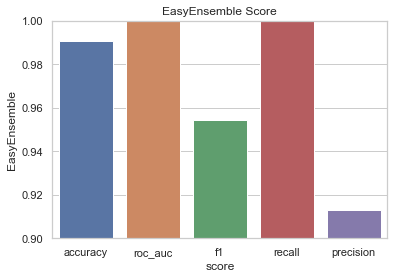

In [226]:
# 다 너무 값이 높아서 확대함.
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="EasyEnsemble", data=score)
ax.set_title('EasyEnsemble Score')
ax.set_ylim([0.9, 1])

Text(0.5, 1.0, 'BalanceCascade Score')

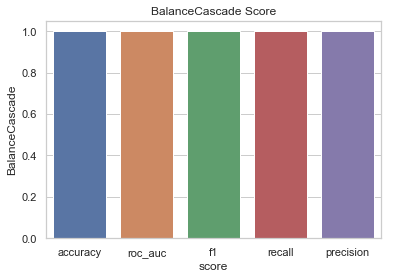

In [224]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="BalanceCascade", data=score)
ax.set_title('BalanceCascade Score')

(0.9985, 1)

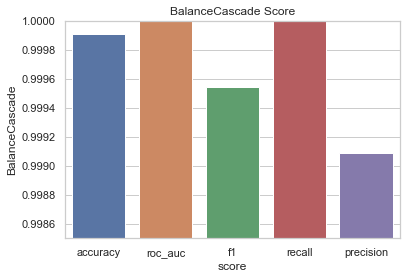

In [232]:
# 다 너무 값이 높아서 확대함.
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="score", y="BalanceCascade", data=score)
ax.set_title('BalanceCascade Score')
ax.set_ylim([0.9985, 1])

## 불균형(원본)데이터 & 모델 적용 후 데이터 recall & precision 값 비교

In [235]:
score

,BaseLine,NearMiss1,NearMiss3,RandomUnderSampler,ENN,Repeated_edites_nearest_neighbor,Tomek_Link_Removal,Random_Oversampling_of_minority_class,SMOTE,SMOTE1,SMOTE2,SMOTE+TOMEK,SMOTE+ENN,EasyEnsemble,BalanceCascade,score
accuracy,0.900166,0.272204,0.603830,0.695131,0.887360,0.865545,0.899201,0.893628,0.878699,0.881208,0.878802,0.874670,0.845352,0.990631,0.999910,accuracy
roc_auc,1.000000,0.475799,0.867082,0.725549,0.712786,0.717582,0.709425,0.717297,0.717297,0.717297,0.717297,0.737709,0.738127,0.999893,1.000000,roc_auc
f1,0.134553,0.168678,0.247605,0.288093,0.211532,0.254584,0.152197,0.193580,0.285173,0.265010,0.269830,0.281752,0.301882,0.954625,0.999543,f1
recall,0.078741,0.749151,0.661400,0.625881,0.153304,0.232959,0.091799,0.129538,0.245495,0.217289,0.227213,0.249412,0.339253,1.000000,1.000000,recall
precision,0.462069,0.095039,0.152313,0.187110,0.341081,0.280636,0.444937,0.382864,0.340148,0.339592,0.332124,0.323729,0.271928,0.913189,0.999087,precision


In [236]:
score2 = score.loc[['recall','precision'],:]
score2

,BaseLine,NearMiss1,NearMiss3,RandomUnderSampler,ENN,Repeated_edites_nearest_neighbor,Tomek_Link_Removal,Random_Oversampling_of_minority_class,SMOTE,SMOTE1,SMOTE2,SMOTE+TOMEK,SMOTE+ENN,EasyEnsemble,BalanceCascade,score
recall,0.078741,0.749151,0.661400,0.625881,0.153304,0.232959,0.091799,0.129538,0.245495,0.217289,0.227213,0.249412,0.339253,1.000000,1.000000,recall
precision,0.462069,0.095039,0.152313,0.187110,0.341081,0.280636,0.444937,0.382864,0.340148,0.339592,0.332124,0.323729,0.271928,0.913189,0.999087,precision


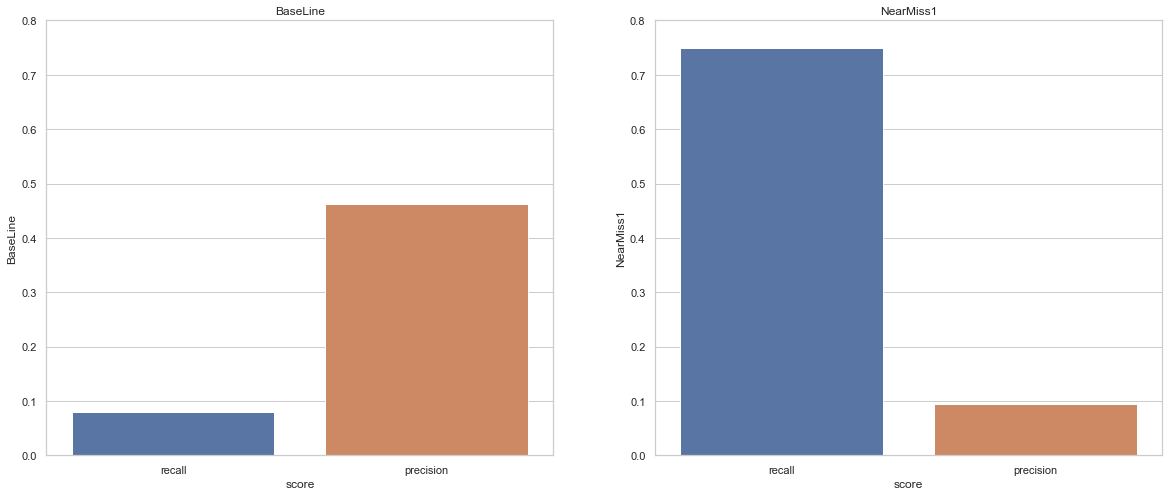

In [240]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.8])
sns.barplot(x="score", y="NearMiss1", data=score2, ax=ax[1])
ax[1].set_title('NearMiss1')
ax[1].set_ylim([0, 0.8])
plt.show()

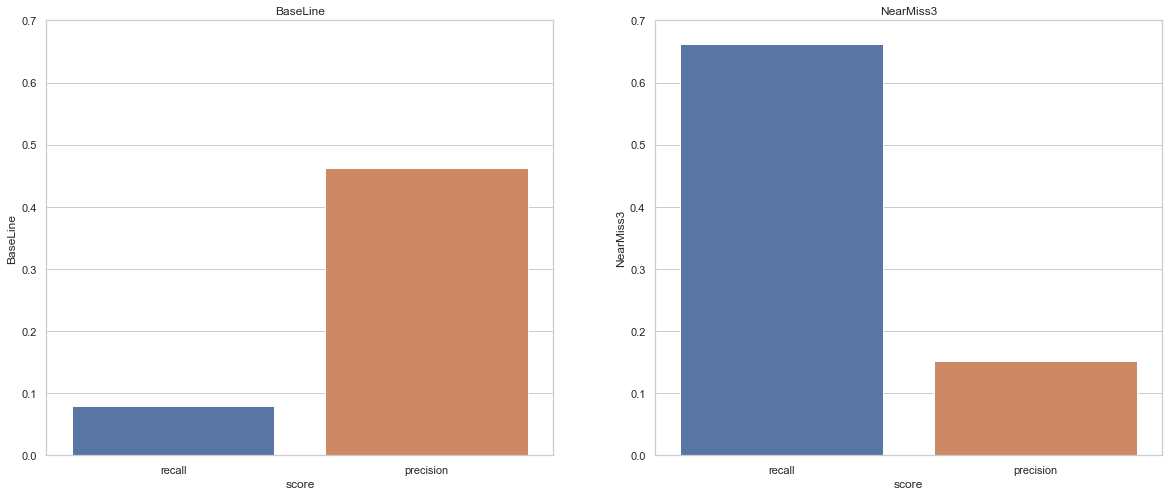

In [242]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.7])
sns.barplot(x="score", y="NearMiss3", data=score2, ax=ax[1])
ax[1].set_title('NearMiss3')
ax[1].set_ylim([0, 0.7])
plt.show()

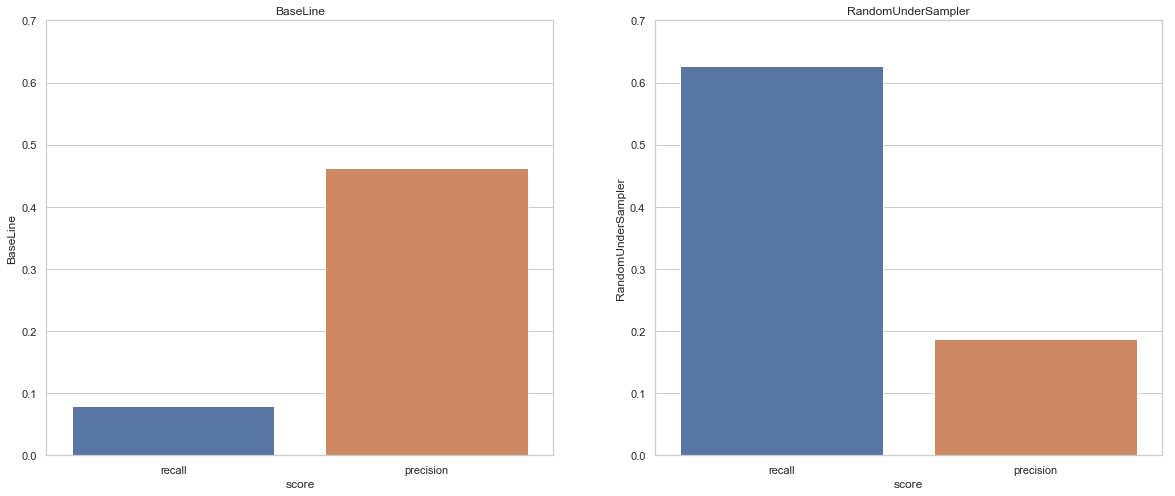

In [243]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.7])
sns.barplot(x="score", y="RandomUnderSampler", data=score2, ax=ax[1])
ax[1].set_title('RandomUnderSampler')
ax[1].set_ylim([0, 0.7])
plt.show()

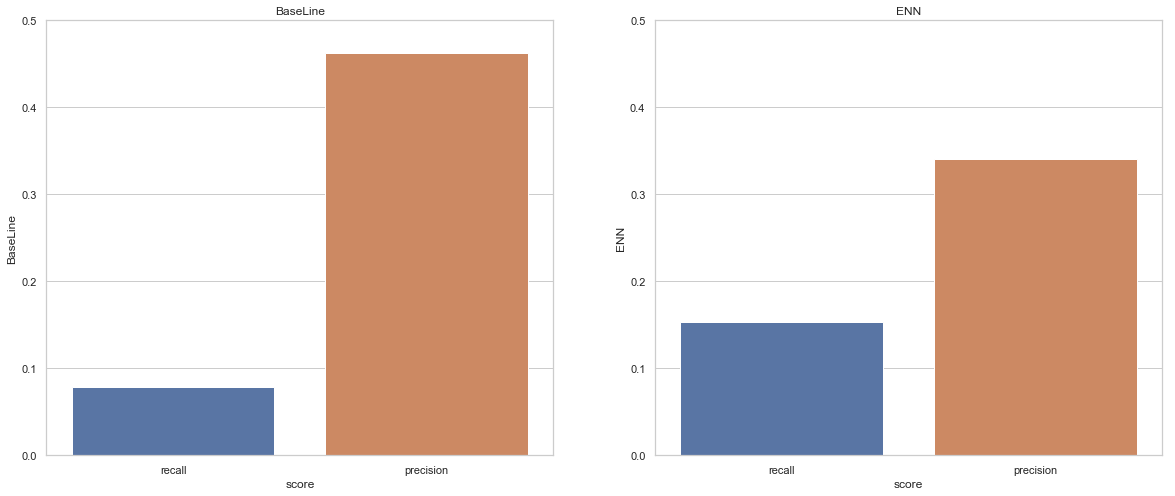

In [245]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.5])
sns.barplot(x="score", y="ENN", data=score2, ax=ax[1])
ax[1].set_title('ENN')
ax[1].set_ylim([0, 0.5])
plt.show()

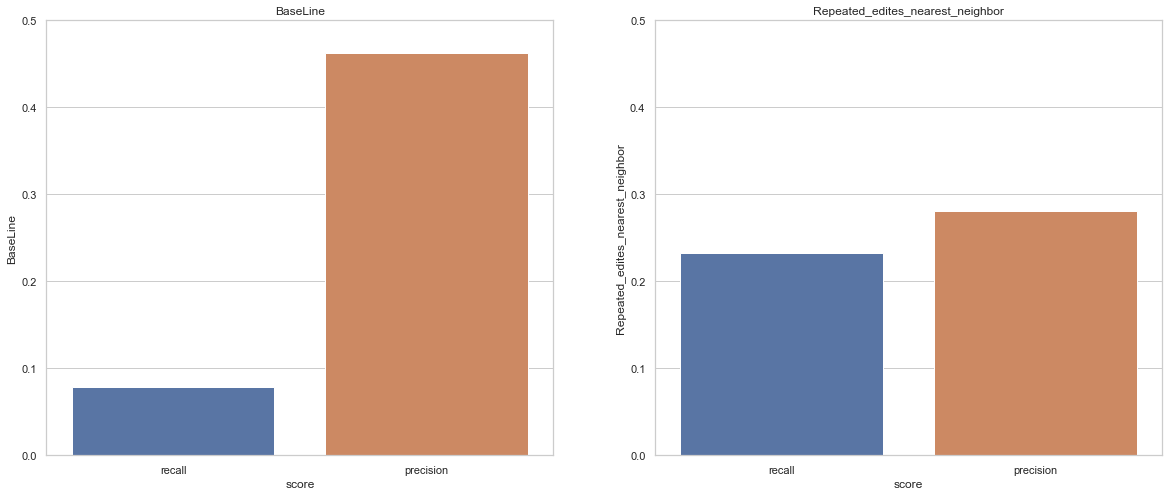

In [247]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.5])
sns.barplot(x="score", y="Repeated_edites_nearest_neighbor", data=score2, ax=ax[1])
ax[1].set_title('Repeated_edites_nearest_neighbor')
ax[1].set_ylim([0, 0.5])
plt.show()

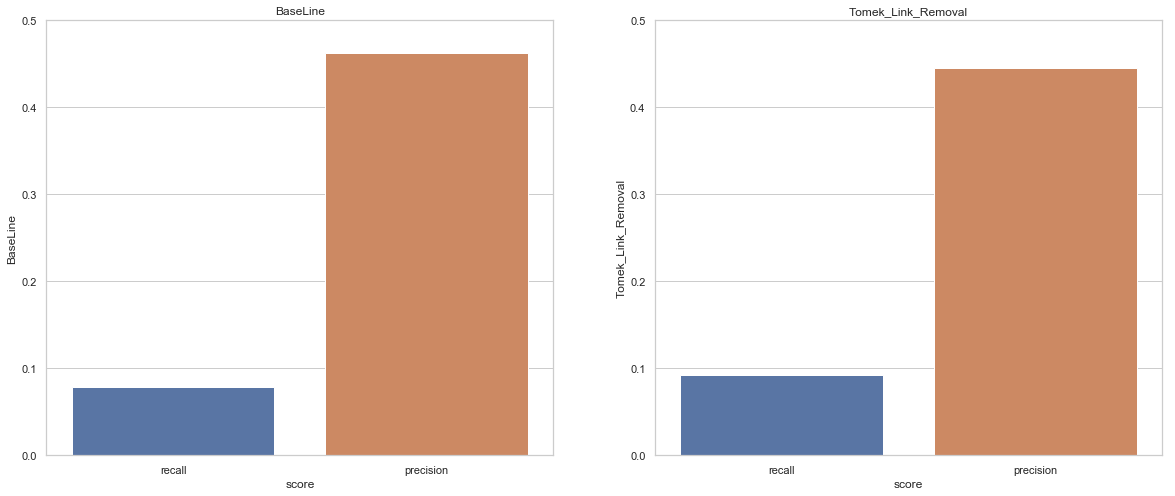

In [249]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.5])
sns.barplot(x="score", y="Tomek_Link_Removal", data=score2, ax=ax[1])
ax[1].set_title('Tomek_Link_Removal')
ax[1].set_ylim([0, 0.5])
plt.show()

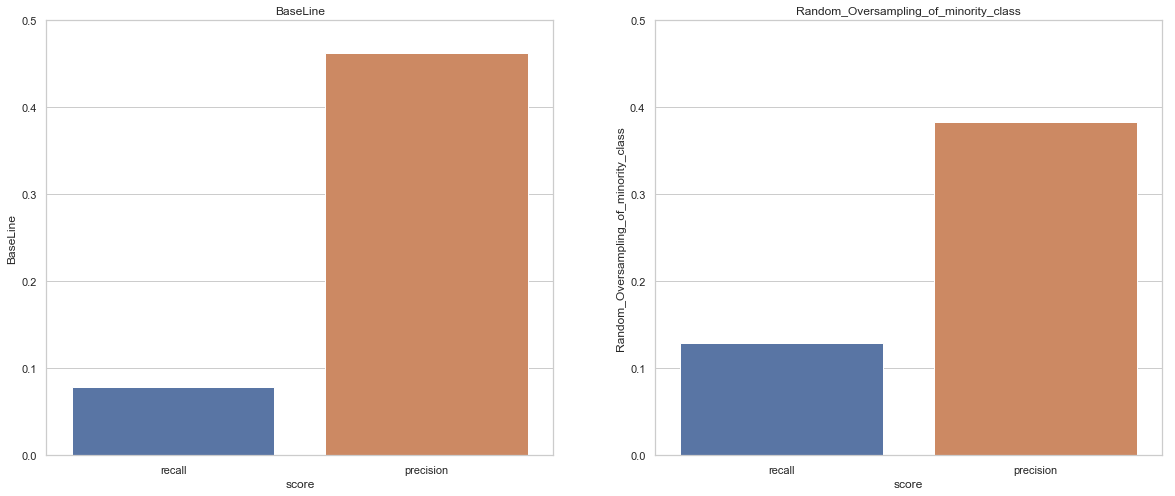

In [251]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.5])
sns.barplot(x="score", y="Random_Oversampling_of_minority_class", data=score2, ax=ax[1])
ax[1].set_title('Random_Oversampling_of_minority_class')
ax[1].set_ylim([0, 0.5])
plt.show()

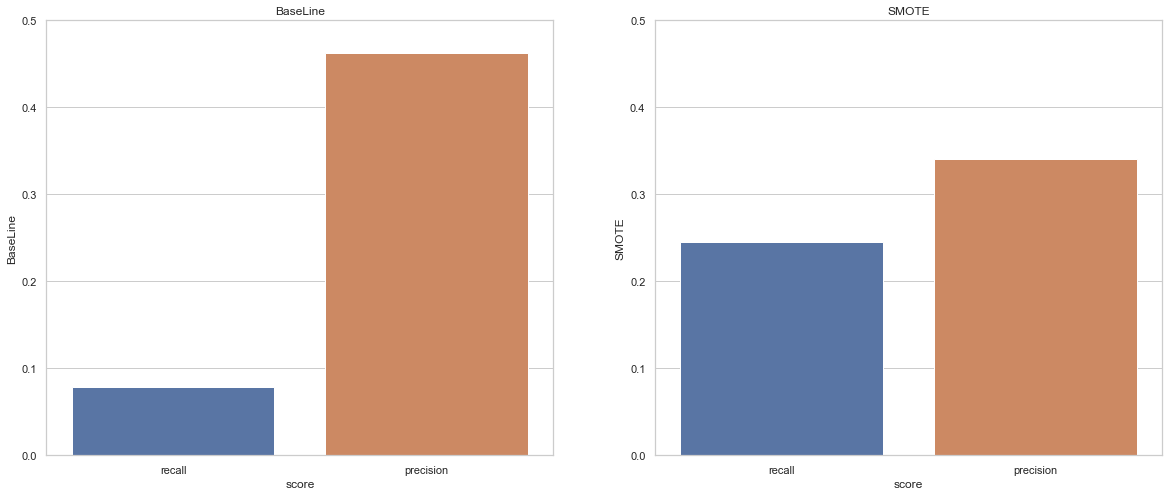

In [253]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.5])
sns.barplot(x="score", y="SMOTE", data=score2, ax=ax[1])
ax[1].set_title('SMOTE')
ax[1].set_ylim([0, 0.5])
plt.show()

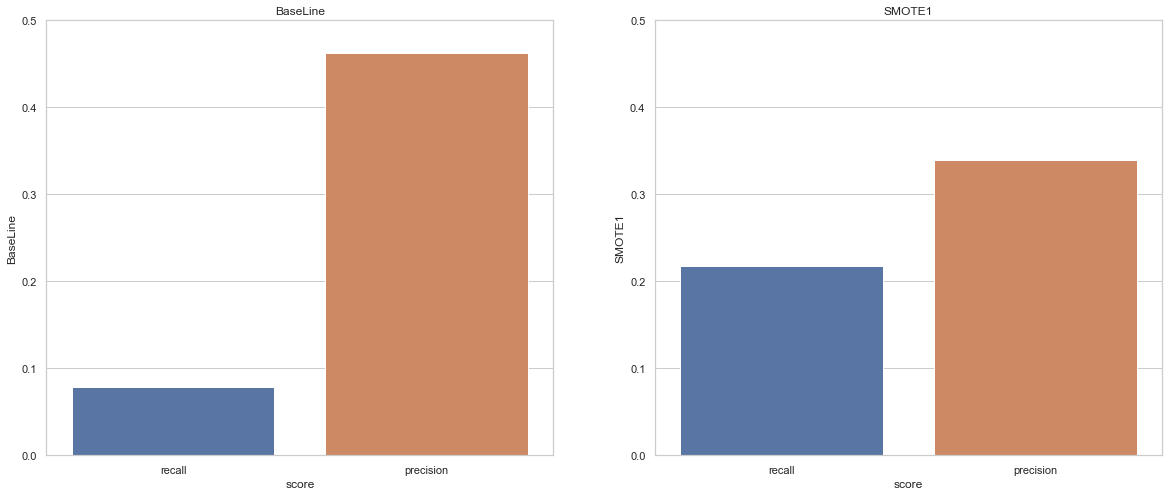

In [255]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.5])
sns.barplot(x="score", y="SMOTE1", data=score2, ax=ax[1])
ax[1].set_title('SMOTE1')
ax[1].set_ylim([0, 0.5])
plt.show()

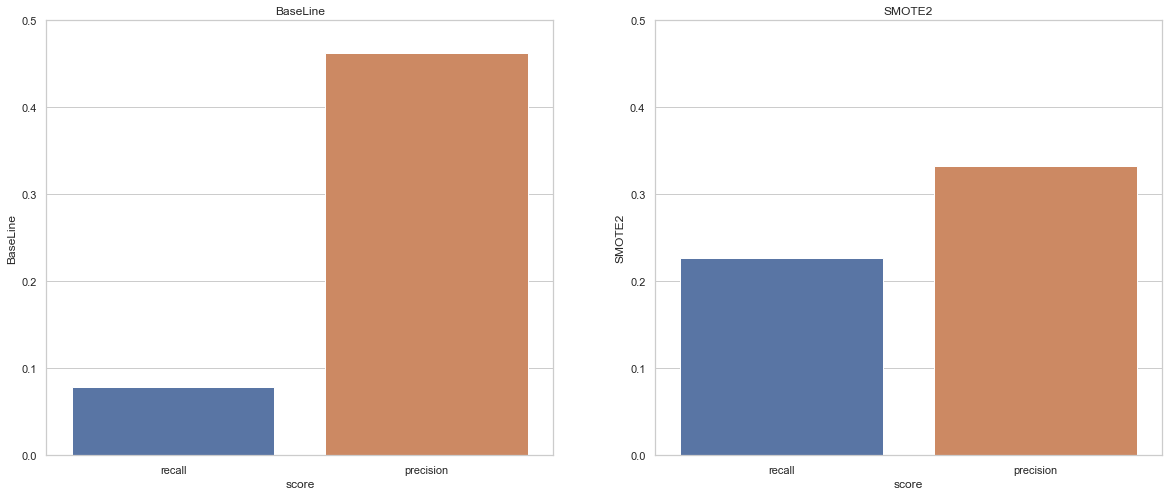

In [257]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.5])
sns.barplot(x="score", y="SMOTE2", data=score2, ax=ax[1])
ax[1].set_title('SMOTE2')
ax[1].set_ylim([0, 0.5])
plt.show()

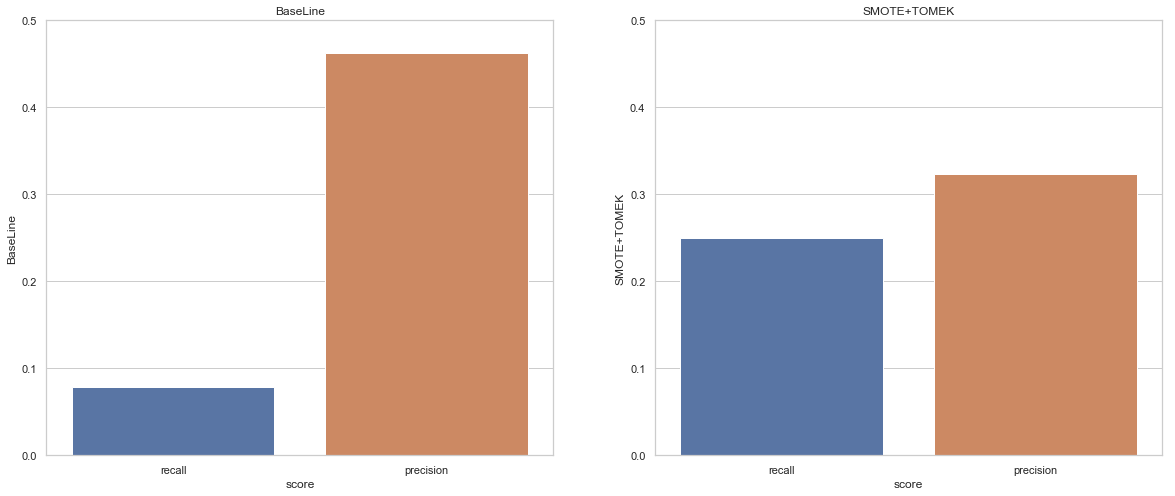

In [258]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.5])
sns.barplot(x="score", y="SMOTE+TOMEK", data=score2, ax=ax[1])
ax[1].set_title('SMOTE+TOMEK')
ax[1].set_ylim([0, 0.5])
plt.show()

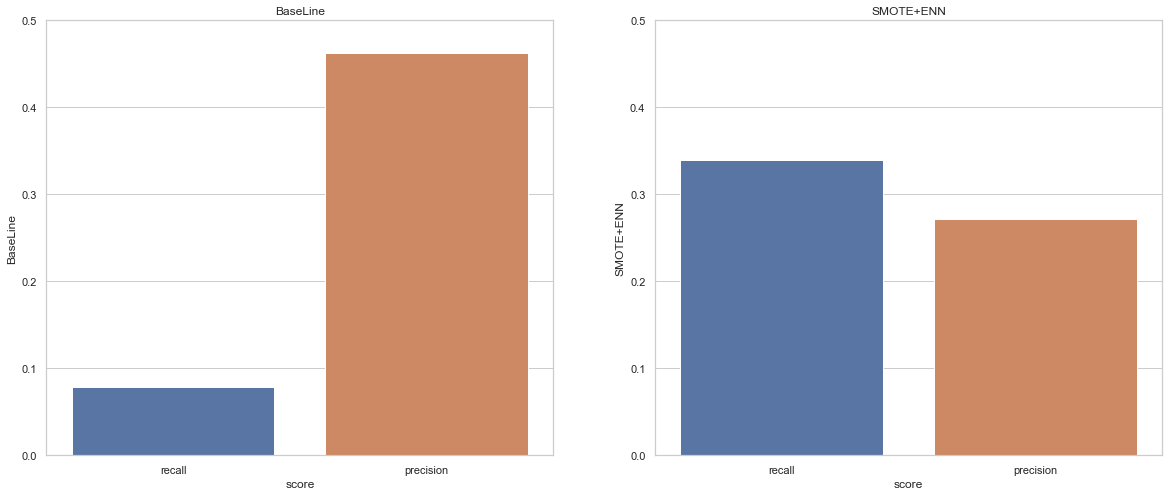

In [259]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 0.5])
sns.barplot(x="score", y="SMOTE+ENN", data=score2, ax=ax[1])
ax[1].set_title('SMOTE+ENN')
ax[1].set_ylim([0, 0.5])
plt.show()

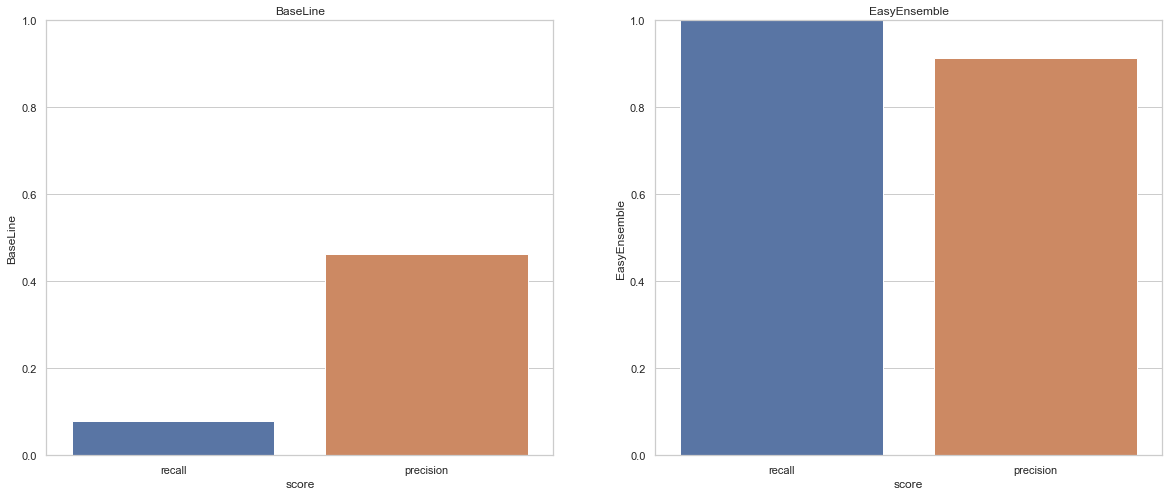

In [262]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 1])
sns.barplot(x="score", y="EasyEnsemble", data=score2, ax=ax[1])
ax[1].set_title('EasyEnsemble')
ax[1].set_ylim([0, 1])
plt.show()

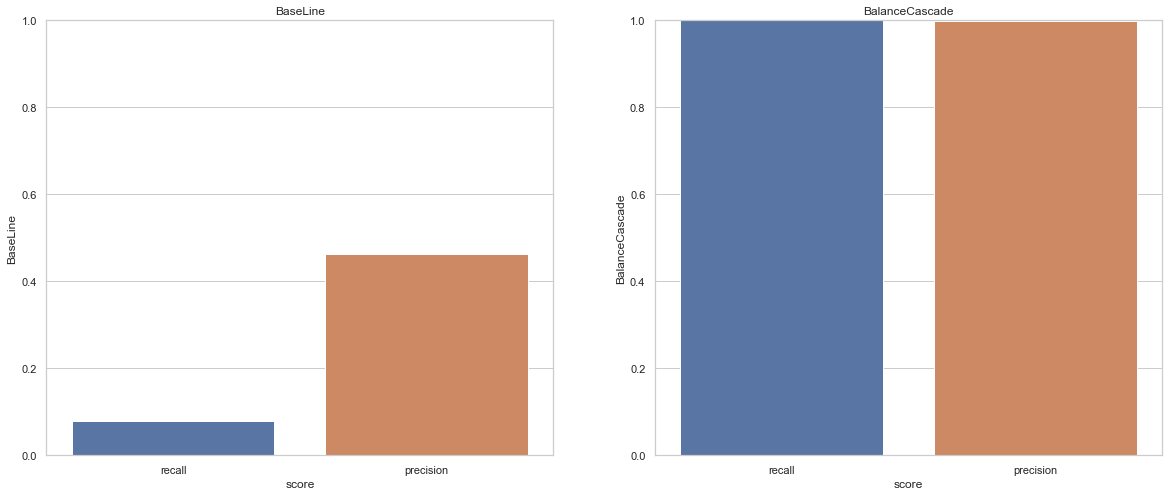

In [263]:
f, ax = plt.subplots(1, 2, figsize=(20,8)) 
sns.barplot(x="score", y="BaseLine", data=score2, ax=ax[0])
ax[0].set_title('BaseLine')
ax[0].set_ylim([0, 1])
sns.barplot(x="score", y="BalanceCascade", data=score2, ax=ax[1])
ax[1].set_title('BalanceCascade')
ax[1].set_ylim([0, 1])
plt.show()